<a href="https://colab.research.google.com/github/salma71/blog_post/blob/master/Evaluate_ML_algos_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will compare the performance of using different methods to evaluate the performance of a machine learning algorithm. 

The methods that would be used are: 
1. Split train-test
2. k-fold cross validation
3. Leave one out cross validation
4. Repeated randome test splits



# 1.1 split into train test 



In [7]:
!pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salmaeng","key":"231d5b452cf64da4dc6c6ff6eb15b34a"}'}

In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [10]:

#Make directory named kaggle and copy kaggle.json file there.
#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 17.4MB/s]


In [12]:
#unzip the folder
!mkdir train
!unzip pima-indians-diabetes-database.zip -d train

Archive:  pima-indians-diabetes-database.zip
  inflating: train/diabetes.csv      


In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [13]:
# load the data
data = pd.read_csv('/content/train/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
data.shape

(768, 9)

In [14]:
# split into train and test
array = data.values

In [26]:
X = data.iloc[:, :-1].values
X.shape

(768, 8)

In [27]:
y = data.iloc[:, -1].values
y.shape

(768,)

In [59]:
seed = 7
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33,
    stratify = y,
    random_state = 7
)


In [60]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
result = model.score(x_test, y_test)
print(f'accuracy is: {result*100.0: 0.3f}')

accuracy is:  76.378


# 2 K-fold cross validation 


In [61]:
from sklearn.model_selection import KFold, cross_val_score


In [62]:
seed = 7
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33,
    stratify = y, # I used stratified to split the dataset with imbalance class equally accross the splits
    random_state = 7
)

In [63]:
kfold = KFold(n_splits = 10, random_state = 7)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [64]:
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv=kfold)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.776 (0.052)


We got a better accuracy with the kfold cross validation. Now, I want to investigate to see the distribution of the accuracy for each fold.
I will make use of the `RepeatedFold()` class with the `sklearn` package

In [75]:
from sklearn.model_selection import RepeatedKFold
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt

cv_repeated = RepeatedKFold(
    n_splits = 10,
    n_repeats = 3,
    random_state = 7
)

In [71]:
scores_r = cross_val_score(
    model,
     X, y,
     scoring = 'accuracy',
     cv = cv_repeated,
     n_jobs = -1
)

print('Accuracy: %.3f (%.3f)' % (scores_r.mean(), scores_r.std()))

Accuracy: 0.774 (0.046)


In [72]:
# define a function to evaluate a model with a given number of repeats
def asses_model(X, y, repeats):
  # define the cv folds 
  cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state = 7)
  # create the model 
  model = LogisticRegression(max_iter=1000)
  # evaluate model 
  scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs=-1)
  return scores

Calculate standard error for a sample using `sem()` within `scipy` package

In [76]:
repeats = range(1, 16)
res = list()
for rep in repeats:
  scores = asses_model(X, y, rep)
  print('>%d mean=%.4f se=%.3f' % (rep, np.mean(scores), sem(scores)))
  res.append(scores)

>1 mean=0.7722 se=0.017
>2 mean=0.7728 se=0.012
>3 mean=0.7743 se=0.009
>4 mean=0.7751 se=0.007
>5 mean=0.7756 se=0.006
>6 mean=0.7745 se=0.006
>7 mean=0.7746 se=0.005
>8 mean=0.7749 se=0.005
>9 mean=0.7745 se=0.004
>10 mean=0.7744 se=0.004
>11 mean=0.7749 se=0.004
>12 mean=0.7748 se=0.004
>13 mean=0.7746 se=0.004
>14 mean=0.7746 se=0.004
>15 mean=0.7746 se=0.003


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<function matplotlib.pyplot.show>

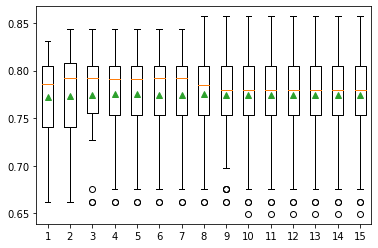

In [77]:
# plot thsose results to compare
plt.boxplot(res, labels=[str(rep) for rep in repeats], showmeans=True)
plt.show

The orange line represents the median of the distribution. However the grean triangle indicates the arthmetic mean.

From the graph above, we may consider a number of folds to harness. nine(9) folds seems to be a good choice. 